In [1]:
from gf_lanczos import build_gf_lanczos
from espace import build_espace
from lookup import get_sector_index

In [2]:
from transport.greenfunction import GreenFunction
from gpaw import GPAW
from gpaw.lcao.pwf2 import LCAOwrap

calc = GPAW('/home/gag/ownCloud/PTM/nospin/gs.gpw', txt=None)
lcao = LCAOwrap(calc)

H = lcao.get_hamiltonian()
S = lcao.get_overlap()

H -= calc.get_fermi_level() * S

atoms = calc.atoms

gf0  = GreenFunction(H, S, selfenergies=[])

central_carbon = 22

gf0.get_activespace(calc, central_carbon, key=lambda eig: abs(eig)<3)

gf0.set(eta=0.02)
gf0.initialize()

/home/gag/anaconda3/lib/python3.7/site-packages/ase/io/jsonio.py:122: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  a = np.array(obj)


Condition number: 4.1e+04


In [8]:
eta = gf0.eta
gf0.selfenergies[0].eta = gf0.eta

In [10]:
def hybrid(sigma):
    def inner(z):
        res = np.zeros(len(z), complex)
        for iz_, z_ in enumerate(z):
            res[iz_] = sigma.retarded(z_-1.j*sigma.eta)
        return res
    return inner

sigma = hybrid(gf0.selfenergies[0])
# sigma = hybrid(gf0)

In [11]:
import fit
reload(fit)

<module 'fit' from '/home/gag/Libraries/edpyt/edpyt/fit.py'>

In [13]:
Delta = fit.fit_hybrid(sigma, nbath=10, nmats=100)

         Current function value: 0.000813
         Iterations: 505
         Function evaluations: 12633
         Gradient evaluations: 601


In [14]:
energies = np.arange(-2,2,1e-2)

In [15]:
expected = np.zeros(len(energies), complex)
for e, energy in enumerate(energies):
    expected[e] = gf0.selfenergies[0].retarded(energy)

In [16]:
computed = Delta(energies+1.j*eta)

In [28]:
np.savetxt('a.txt', Delta.a)
np.savetxt('b.txt', Delta.b)

In [126]:
2*expected.imag[np.abs(energies)<1e-3]

array([-0.07111064])

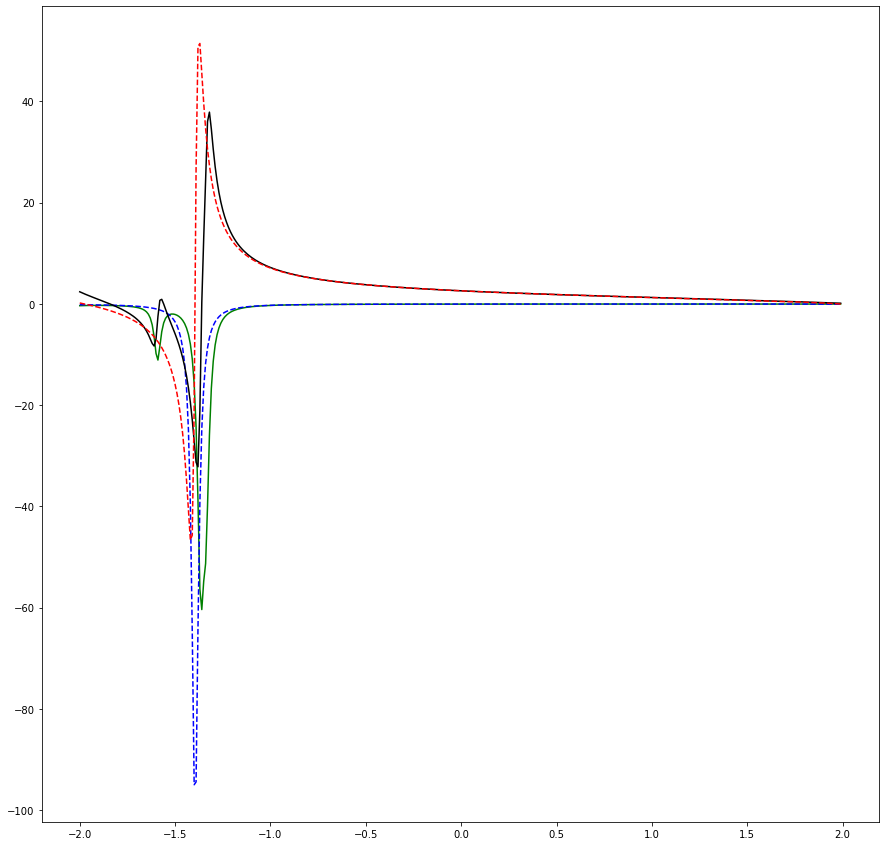

In [121]:
plt.figure(figsize=(15,15))
plt.plot(energies, expected.imag, 'g-', energies, computed.imag, 'b--')
plt.plot(energies, expected.real, 'k-', energies, computed.real, 'r--')

In [18]:
from shared import params

In [19]:
params['hfmode'] = True

In [39]:
n = Delta.a.size + 1
H = np.zeros((n,n))
V = np.zeros((n,n))

H[0,1:] = H[1:,0] = Delta.b
for i in range(1,n):
    H[i,i] = Delta.a[i-1]
H[0,0] = gf0.H[0,0]

U = 0.
V[0,0] = U

neig_sector = np.ones((n+1)*(n+1),int)
eigen_space, egs = build_espace(H, V, neig_sector)

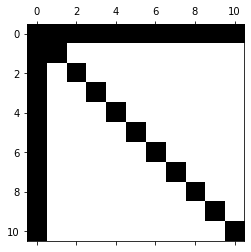

In [113]:
plt.spy(H)

In [50]:
def screen_eigen_space(eigen_space):
    gs_sectors = []
    for (nup, ndw), sct in eigen_space.items():
        if abs(sct.eigvals-egs) < 1e-3:
            gs_sectors.append((nup, ndw))
    gs_space = {k:v for k, v in eigen_space.items() if k in gs_sectors}
    return gs_space

In [44]:
gf = build_gf_lanczos(H, V, eigen_space_gs, 0.)

energies = np.arange(-2,2,1e-2)

dos = -1/np.pi*gf(energies, eta).imag

In [45]:
gf_analytic = lambda z: 1/(z-gf0.H[0,0]-Delta(z))

In [46]:
dos_analytic = lambda z: -1/np.pi*gf_analytic(z).imag

In [47]:
dos_orig = np.zeros_like(energies)
for e, energy in enumerate(energies):
    dos_orig[e] = gf0.dos(energy)

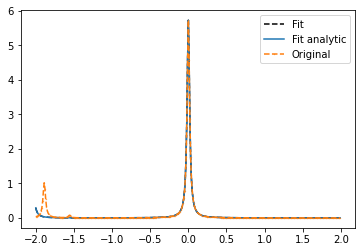

In [48]:
plt.plot(energies, dos_analytic(energies+1.j*eta), 'k--', label='Fit')
plt.plot(energies, dos, '-', label='Fit analytic')
plt.plot(energies, dos_orig, '--o', markersize=0.3, label='Original')
plt.legend()

In [49]:
U = 4.
V[0,0] = U

In [56]:
params['hfmode']

True

In [51]:
eigen_space, egs = build_espace(H, V, neig_sector)

In [52]:
gs_space = screen_eigen_space(eigen_space)

In [53]:
gf = build_gf_lanczos(H, V, gs_space, 0.)

In [54]:
dos = -1/np.pi*gf(energies, eta).imag

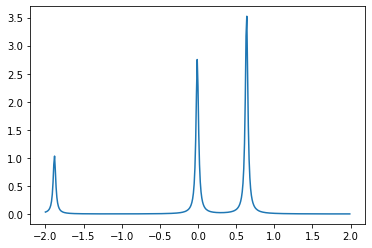

In [55]:
plt.plot(energies, dos)

In [69]:
U = 6.
V[0,0] = U

In [58]:
params['hfmode']

True

In [70]:
eigen_space, egs = build_espace(H, V, neig_sector)

In [71]:
gs_space = screen_eigen_space(eigen_space)

In [72]:
gf = build_gf_lanczos(H, V, gs_space, 0.)

In [106]:
dos = -1/np.pi*gf(energies, eta).imag

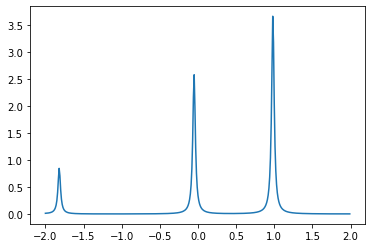

In [107]:
plt.plot(energies, dos)

In [108]:
dos = -1/np.pi*gf(energies, 0.5*np.abs(energies+0.049)).imag

In [119]:
z = energies + 1.j*eta*np.abs(energies)

In [120]:
eta

0.02

(0.0, 2.0)

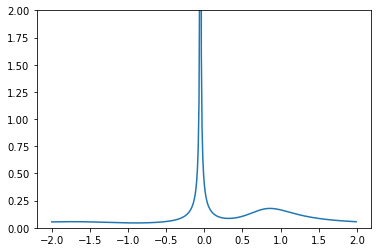

In [110]:
plt.plot(energies, dos)
plt.ylim(0,2)